In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [4]:
#posicion de los nodos coordenadas
nodos = np.array([
    (0,0),
    (10,0),
    (10,10),
 ])

# una lista de nodos y grados de libertad
N_NODOS = np.array([*range(len(nodos))])
NODOS_GDL = np.array([*range(3*len(nodos))])


In [6]:
#especificando cada elemento, si faltan agregar mas
# [nodoi,nodoj, E, area, I]

ELEMENTOS = np.array([
    [1, 2, 1, 100, 1],
    [2, 3, 1, 50, 1],
    [1, 3, 1, 200*math.sqrt(2), 1]
])

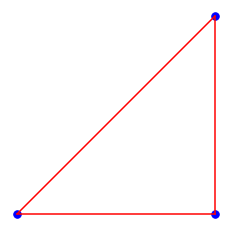

In [7]:
#configurando matplotlib
plt.axes().set_aspect('equal')
plt.axis('off')

#dibujando los nodos
plt.plot(nodos[:,0], nodos[:,1], 'k.', markersize= 15, color='b')

#dibujando elementos
#es un loop alrededor de la matriz ELEMENTOS, tomando los
#valores de X y Y de cada elemento

for i in range(len(ELEMENTOS)):
    plt.plot(np.array([
    nodos[int(ELEMENTOS[i,0]-1),0], nodos[int(ELEMENTOS[i,1]-1),0]]),
        np.array([nodos[int(ELEMENTOS[i,0]-1),1], nodos[int(ELEMENTOS[i,1]-1),1]]),
        'k-', color='r'
    )

plt.show()

In [8]:
# CONDICIONES DE FRONTERA
# CF = [nodo, GDL(x=1 ,y=2, theta=3), valor]

CF = np.array([
    (2,1,0),
    (3,1,0),
    (3,2,0),
    (3,3,0)
])
CF

array([[2, 1, 0],
       [3, 1, 0],
       [3, 2, 0],
       [3, 3, 0]])

In [9]:
# FUERZAS
# FUERZAS = (nodo,GDL(x=1,y=2),magnitud de la fuerza)

FUERZAS = np.array([
    (2,1,0),

    (3,1,10),
    (3,2,1)
])
FUERZAS


array([[ 2,  1,  0],
       [ 3,  1, 10],
       [ 3,  2,  1]])

In [10]:
# HALLANDO MATRICES DE RIGIDEZ POR ELEMENTO
F = np.zeros(3*len(nodos))
K = np.zeros([3*len(nodos),3*len(nodos)])


In [11]:
#funcion que retorna valor de coordenadas en cada elemento
def XY(nodos,ELEMENTOS,i):
    return np.array([
        nodos[int(ELEMENTOS[i,0]-1)],
        nodos[int(ELEMENTOS[i,1]-1)]
    ])


In [12]:
# colocar numero de elemento para generar matri
N_ELEMENTO = 1
sp.Matrix(XY(nodos,ELEMENTOS,N_ELEMENTO-1))


Matrix([
[ 0, 0],
[10, 0]])

In [13]:
#funcion para matriz de rigidez de cada elemento
def KEL(XY, E, A):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)

    KEL = E*A/L * np.array([
        (1,0,-1,0),
        (0,0,0,0),
        (-1,0,1,0),
        (0,0,0,0)
    ])
    return KEL


In [14]:
#matriz de rigidez global del elemento
N_ELEMENTO = 3

sp.Matrix(KEL(XY(nodos, ELEMENTOS,N_ELEMENTO-1),
          ELEMENTOS[N_ELEMENTO-1,2],
          ELEMENTOS[N_ELEMENTO-1,3]
          ))

Matrix([
[ 20.0, 0.0, -20.0, 0.0],
[  0.0, 0.0,   0.0, 0.0],
[-20.0, 0.0,  20.0, 0.0],
[  0.0, 0.0,   0.0, 0.0]])

In [15]:
# matriz de rigidez en coordenadas globales

def KGEL(XY, E, A):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)

    if x2-x1==0:
        c = 0
        s = 1
    else:
        theta = math.atan((y2-y1)/(x2-x1))
        c = np.cos(theta)
        s = np.sin(theta)

    KGEL = E*A/L * np.array([
        (c**2, s*c, -c**2, -s*c),
        (s*c, s**2, -s*c, -s**2),
        (-c**2, -s*c, c**2, s*c),
        (-s*c, -s**2, s*c, s**2)
    ])
    return KGEL



In [16]:
#ejemplo matriz global de un elemento
N_ELEMENTO = 3


sp.Matrix(KGEL(XY(nodos, ELEMENTOS,N_ELEMENTO-1),
          ELEMENTOS[N_ELEMENTO-1,2],
          ELEMENTOS[N_ELEMENTO-1,3]
          ))



Matrix([
[ 10.0,  10.0, -10.0, -10.0],
[ 10.0,  10.0, -10.0, -10.0],
[-10.0, -10.0,  10.0,  10.0],
[-10.0, -10.0,  10.0,  10.0]])

In [17]:
#definiendo posición matriz ensamblada
def GDL(ELEMENTOS,i):
    nodo_GDL_i = int(ELEMENTOS[i-1,:2][0])
    nodo_GDL_j = int(ELEMENTOS[i-1,:2][1])
    elemento_GDL = np.array([
        (2*nodo_GDL_i-1),
        (2*nodo_GDL_i),
        (2*nodo_GDL_j-1),
        (2*nodo_GDL_j)
    ])
    return elemento_GDL


In [19]:
E_1 = KGEL(XY(nodos, ELEMENTOS,N_ELEMENTO-1),
          ELEMENTOS[N_ELEMENTO-1,2],
          ELEMENTOS[N_ELEMENTO-1,3]
          )
E_1


array([[ 10.,  10., -10., -10.],
       [ 10.,  10., -10., -10.],
       [-10., -10.,  10.,  10.],
       [-10., -10.,  10.,  10.]])

In [23]:
# primera prueba funcion emsamblada
def ENSAMBLADA(N_ELEMENTO):
    M_ENSAMBLADA = np.zeros([2*len(nodos),2*len(nodos)])
    E_i = KGEL(XY(nodos, ELEMENTOS,N_ELEMENTO-1),
          ELEMENTOS[N_ELEMENTO-1,2],
          ELEMENTOS[N_ELEMENTO-1,3]
          )
    GDL_i = GDL(ELEMENTOS,N_ELEMENTO)

    for i in range(0,4):
        for j in range(0,4):
            M_ENSAMBLADA[GDL_i[i]-1,GDL_i[j]-1] = E_i[i,j]

    return M_ENSAMBLADA


In [25]:
# creando matriz de rigidez global MKTOTAL (READY)
def KGLOBAL():
    KGLOBAL = np.zeros([2*len(nodos),2*len(nodos)])

    for i in range(1,len(ELEMENTOS)+1):
        ki = ENSAMBLADA(i)
        KGLOBAL += ki
    return KGLOBAL

In [26]:
# MATRIZ RIGIDEZ GLOBAL
K_GLOBAL = KGLOBAL()
sp.Matrix(KGLOBAL())

Matrix([
[ 20.0,  10.0, -10.0,  0.0, -10.0, -10.0],
[ 10.0,  10.0,   0.0,  0.0, -10.0, -10.0],
[-10.0,   0.0,  10.0,  0.0,   0.0,   0.0],
[  0.0,   0.0,   0.0,  5.0,   0.0,  -5.0],
[-10.0, -10.0,   0.0,  0.0,  10.0,  10.0],
[-10.0, -10.0,   0.0, -5.0,  10.0,  15.0]])

In [27]:
#FASE SOLUCIÓN
# declarando condiciones de frontera
# especificar condiciones de cada nudo
#por ejemplo 0= movimiento restringido 1= con movimiento
T_NODO = np.array([
    (1,0,0),
    (2,0,1),
    (3,1,1)
])

M_u = np.array(len(nodos))




In [28]:
sp.Matrix(FUERZAS)

Matrix([
[2, 1,  0],
[3, 1, 10],
[3, 2,  1]])

In [29]:
#funcion para reducir matriz global
def f_red():
    n = np.array([])
    for i in range(len(FUERZAS)):
        m= np.array((FUERZAS[i,0] * 2 - 3 ) + (FUERZAS[i,1]))
        n = np.insert(n,i,m)
    return n
#matriz de valores para reducir
v_red = f_red()

In [30]:
#matriz reducida
def KRed():
    KRed = np.empty([len(FUERZAS),len(FUERZAS)])
    for i in range(len(FUERZAS)):
        for j in range(len(FUERZAS)):
            z = f_red()
            a = int(z[i])
            b = int(z[j])
            KRed[i, j] = K_GLOBAL[a,b]
    return KRed

KRed= KRed()
sp.Matrix(KRed)

Matrix([
[10.0,  0.0,  0.0],
[ 0.0, 10.0, 10.0],
[ 0.0, 10.0, 15.0]])

In [31]:
#matriz de fuerza
F = FUERZAS[0:,2]
sp.Matrix(F)


Matrix([
[ 0],
[10],
[ 1]])

In [32]:
#hallando dezplazamientos desconocidos
#matriz inverza de la reducida
Kred_inv = np.linalg.inv(KRed)
sp.Matrix(Kred_inv)


Matrix([
[0.1,  0.0,  0.0],
[0.0,  0.3, -0.2],
[0.0, -0.2,  0.2]])

In [33]:
#multiplicacion con la matriz de fuerzas
u_desc = np.matmul(Kred_inv,F)
#valores de dezplazamiento
sp.Matrix(u_desc)


Matrix([
[ 0.0],
[ 2.8],
[-1.8]])

In [34]:
#declarar valores de dezplazamiento si las hay (matriz u)
u = np.empty([2*len(nodos)])

for i in range(len(v_red)):
    u[int(v_red[i])]= u_desc[i]

sp.Matrix(u)


Matrix([
[ 0.0],
[ 0.0],
[ 0.0],
[ 0.0],
[ 2.8],
[-1.8]])

In [35]:
# resultados Fuerzas faltantes
F_des = np.matmul(K_GLOBAL,u)
sp.Matrix(F_des)

Matrix([
[-10.0],
[-10.0],
[  0.0],
[  9.0],
[ 10.0],
[  1.0]])

In [36]:
#definicion de nodos desplazados
n_nodos = nodos + u.reshape(len(nodos),2)

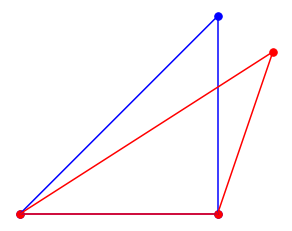

In [37]:
# PLOTEO ARMADURA 
plt.axes().set_aspect('equal')
plt.axis('off')
#elemento inicial
plt.plot(nodos[:,0], nodos[:,1], 'k.', markersize= 15, color='b')
#elemento desplazado
plt.plot(n_nodos[:,0], n_nodos[:,1], 'k.', markersize= 15, color='r')
#elemento inicial
for i in range(len(ELEMENTOS)):
    plt.plot(np.array([
    nodos[int(ELEMENTOS[i,0]-1),0], nodos[int(ELEMENTOS[i,1]-1),0]]),
        np.array([nodos[int(ELEMENTOS[i,0]-1),1], nodos[int(ELEMENTOS[i,1]-1),1]]),
        'k-', color='b'
    )
#elemento desplazado
for i in range(len(ELEMENTOS)):
    plt.plot(np.array([
    n_nodos[int(ELEMENTOS[i,0]-1),0], n_nodos[int(ELEMENTOS[i,1]-1),0]]),
        np.array([n_nodos[int(ELEMENTOS[i,0]-1),1], n_nodos[int(ELEMENTOS[i,1]-1),1]]),
        'k-', color='r'
    )

plt.show()